In [ ]:
!pip install livelossplot==0.5.1 --quiet
import torch.nn.functional as F
import gc
import pickle
import h5py
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from skimage.transform import resize
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset
from PIL import Image
from matplotlib import pyplot as plt
from livelossplot import PlotLosses
from google.colab import drive
from os import listdir
from sys import getsizeof
import torch.nn.functional as F
from skimage.transform import resize 
import torch.nn.functional as F
from torchvision import transforms
import scipy.misc
import warnings
warnings.filterwarnings('ignore')
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

In [ ]:
filepath = "/content/drive/My Drive/APS360 Project/"
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class h5Dataset(Dataset):

    def __init__(self, file_path, file_name, func=None):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + file_name, "r")

        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        

    def __getitem__(self, index):
        
        rgb = self.file[self.rgb_dbs[index]][:].astype('uint8')
        depth = self.file[self.depth_dbs[index]][:].astype('float64') / 65535
        if self.func:
            rgb, depth = self.func(rgb, depth)
            
        return rgb, depth

    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

def load_dataset(file_path, file_name, batch_size, ratios=(.7, .15, .15), shuffle=True):

    dataset = h5Dataset(file_path=file_path, file_name=file_name, func=alter)
    
    num_samples = len(dataset)
    len1 = int(num_samples*ratios[0])
    len2 = int(num_samples*ratios[1])

    train_data, val_data, test_data = random_split(dataset,
                                    (len1, len2, num_samples-len1-len2))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0)

    return train_loader, val_loader, test_loader

def alter(rgb, depth):
    
    trans_rgb = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224,224)), transforms.ToTensor()])
    trans_depth = transforms.Compose([transforms.ToPILImage(), transforms.Resize((112,112)), transforms.ToTensor()])

    depth = depth.astype('float32')

    depth = trans_depth(depth)
    depth = transforms.Normalize(0,0.1217)(depth)

    rgb = trans_rgb(rgb)
    return rgb, depth

In [ ]:
train_loader, val_loader, test_loader = load_dataset(
        file_path=filepath,
        file_name="DIML.h5",
        batch_size=32,
        ratios=(.7, .15, .15)
        )

2527 541 543


torch.Size([224, 224, 3]) torch.Size([32, 1, 112, 112])
tensor(0.9147)
tensor(0.0636)
tensor(0.3012)


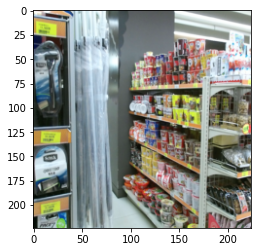

torch.Size([112, 112])


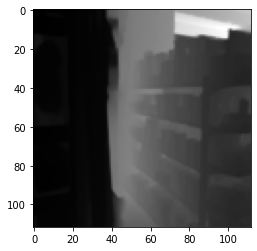

In [ ]:
for i, batch in enumerate(train_loader):
    rgb, depth = batch
    
    print(rgb[0].permute(1, 2, 0).shape, depth.shape)

    print(torch.max(depth))
    print(torch.min(depth))
    print(torch.mean(depth))
    
    plt.imshow(rgb[0].permute(1, 2, 0))
    plt.show()
    
    plt.imshow(depth[0].permute(1,2,0).squeeze(), cmap="gray")
    print(depth[0].squeeze().size())
    plt.show()
    
    break
    

In [ ]:
 class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode)
        return x

## ResNet w/ Autoencoder

In [ ]:
resNet =  torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
new_resNet = nn.Sequential(*list(resNet.children())[:6])
print (new_resNet)

for child in resNet.modules():
    for param in child.parameters():
        param.requires_grad = False


In [ ]:
class resNetModel(nn.Module):
    def __init__(self):
        super(resNetModel, self).__init__()

        self.new_resNet = nn.Sequential(*list(resNet.children())[:6])

        self.conv = nn.Sequential(
            nn.Conv2d(128, 240, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(240, 480, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(480, 960, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
        )

        self.trans_conv = nn.Sequential(               
            nn.ConvTranspose2d(960, 480, kernel_size=3),
            Interpolate(size = (56, 56), mode = 'nearest'),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(480, 240, kernel_size=3, padding = 1),
            Interpolate(size = (112, 112), mode = 'nearest'),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(240, 1, kernel_size=3, padding = 2),
            Interpolate(size = (224,224), mode = 'nearest'),
            nn.Sigmoid(),
        )

    def forward(self, rgb):
      print ("Original RGB Shape: ")
      print (rgb.shape)
      x = self.new_resNet (rgb)
      print ("After Res Nets: ", x.shape)
      x = self.trans_conv(self.conv(x))
      print ("After Convolutions: ", x.shape)
      return x

## DenseNet w/ AutoEncoder

In [ ]:
denseNet_121 =  torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
new_denseNet_121 = nn.Sequential(*list(denseNet_121.children())[:1])
print (new_denseNet_121)

for child in denseNet_121.modules():
    for param in child.parameters():
        param.requires_grad = False

In [ ]:
class denseNetModel_121(nn.Module):
    def __init__(self):
        super(denseNetModel_121, self).__init__()

        self.new_denseNet_121 = nn.Sequential(*list(denseNet_121.children())[:1])

        self.conv = nn.Sequential(
            nn.Conv2d(1024, 1200, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1200, 1300, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1300, 1400, kernel_size=3, padding=1),
            nn.LeakyReLU(),
        )

        self.trans_conv = nn.Sequential(               
            nn.ConvTranspose2d(1400, 1300, kernel_size=3),
            Interpolate(size = (56, 56), mode = 'nearest'),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1300, 1200, kernel_size=3, padding = 1),
            Interpolate(size = (112, 112), mode = 'nearest'),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1200, 1, kernel_size=3, padding = 2),
            Interpolate(size = (224,224), mode = 'nearest'),
            nn.Sigmoid(),
        )

    def forward(self, rgb):
      # print ("Original RGB Shape: ")
      # print (rgb.shape)
      x = self.new_denseNet_121 (rgb)
      # print ("After DenseNets: ", x.shape)
      x = self.trans_conv(self.conv(x))
      # print ("After Convolutions: ", x.shape)
      return x

## MobileNet

In [ ]:
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyrelyA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1280, decoder_width = .6):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)
        
        self.up0 = UpSample(skip_input=features//1 + 320, output_features=features//2)
        self.up1 = UpSample(skip_input=features//2 + 160, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 64, output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 32, output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 +  24, output_features=features//8)
        self.up5 = UpSample(skip_input=features//8 +  16, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)
        

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4,x_block5,x_block6 = features[2], features[4], features[6], features[9], features[15],features[18],features[19]
        x_d0 = self.conv2(x_block6)
        x_d1 = self.up0(x_d0, x_block5)
        x_d2 = self.up1(x_d1, x_block4)
        x_d3 = self.up2(x_d2, x_block3)
        x_d4 = self.up3(x_d3, x_block2)
        x_d5 = self.up4(x_d4, x_block1)
        x_d6 = self.up5(x_d5, x_block0)
        
        return self.conv3(x_d6)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.mobilenet_v2( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, rgb):
        x = self.encoder (rgb)
        x = self.decoder (x) 
        return x

In [ ]:
mobileNet_model = models.mobilenet_v2( pretrained=True )
new_mobileNet_model = nn.Sequential(*list(mobileNet_model.children())[:1])
print (new_mobileNet_model)

for child in mobileNet_model.modules():
    for param in child.parameters():
        param.requires_grad = False

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Sequential(
  (0): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
class mobileNet_(nn.Module):
    def __init__(self):
        super(mobileNet_, self).__init__()

        self.new_mobileNet_model = nn.Sequential(*list(mobileNet_model.children())[:1])

        self.conv = nn.Sequential(
            nn.Conv2d(1280, 1300, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1300, 1400, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1400, 1500, kernel_size=3, padding=1),
            nn.LeakyReLU(),
        )

        self.trans_conv = nn.Sequential(               
            nn.ConvTranspose2d(1500, 1300, kernel_size=3),
            Interpolate(size = (56, 56), mode = 'nearest'),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1300, 1200, kernel_size=3, padding = 1),
            Interpolate(size = (112, 112), mode = 'nearest'),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1200, 1, kernel_size=3, padding = 2),
            Interpolate(size = (224,224), mode = 'nearest'),
            nn.Tanh(),
        )

    def forward(self, rgb):
      print ("Original RGB Shape: ")
      print (rgb.shape)
      x = self.new_mobileNet_model (rgb)
      print ("After Mobile Net: ", x.shape)
      x = self.trans_conv(self.conv(x))
      print ("After Convolutions: ", x.shape)
      return x

## CNN

In [ ]:
class cnnNet (nn.Module):
  def __init__(self):
    super (cnnNet, self).__init__()
    self.conv1 = nn.Conv2d (3, 6, 5)
    self.pool = nn.MaxPool2d (2,2)
    self.conv2 = nn.Conv2d (6, 16, 5)
    self.fc1 = nn.Linear (16*37*37, 120)
    self.fc2 = nn.Linear (120, 84)
    self.fc3 = nn.Linear (84, 1)

  def forward (self, x):
    x = self.pool (F.relu(self.conv1(x)))
    x = self.pool (F.relu(self.conv2(x)))
    x = x.view (-1, 16*37*37)
    x = F.relu (self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
def train(model, batch_size=32, learning_rate=0.01, num_epochs=1, \
          ratios=(.7, .15, .15)):

    torch.autograd.set_detect_anomaly(True)

    plotlosses = PlotLosses()

    torch.manual_seed(1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, \
                                        factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        total_loss = 0.0

        for i, (rgb, depth) in enumerate(train_loader):
            model.train()

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()

            optimizer.zero_grad()
      
            pred = model(rgb.float())
      
            
            loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze()))
            
            val_loss = batch_loss(model, criterion, val_loader)

            scheduler.step(val_loss)

            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            plotlosses.update({
                'loss': loss.item(),
                'val_loss': val_loss
            })

            plotlosses.send()
            fig = plt.figure()
            fig.set_figheight(15)
            fig.set_figwidth(15)
            fig.add_subplot(3,1,1)
            plt.imshow(rgb.float().detach().cpu()[0].permute(1, 2, 0))
            fig.add_subplot(3,1,2)
            plt.imshow(depth.detach().cpu()[0].permute(1, 2, 0).squeeze(), cmap="gray")
            fig.add_subplot(3,1,3)
            plt.imshow(pred.detach().cpu()[0].permute(1, 2, 0).squeeze(), cmap="gray")
            plt.show()

def batch_loss(model, criterion, val_loader):
    with torch.no_grad():
        model.eval()

        total_loss = 0.0

        for i, (rgb, depth) in enumerate(val_loader):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            pred = model(rgb.float())


            del rgb

            loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze())).item()
            del pred, depth
            torch.cuda.empty_cache()

            total_loss += loss

        return total_loss / (i+1)

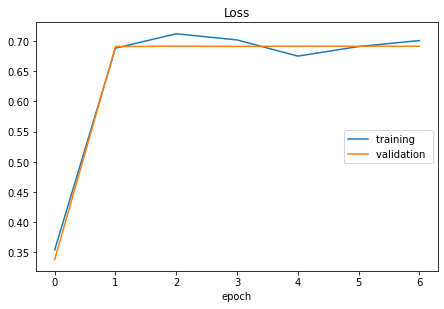

Loss
	training         	 (min:    0.354, max:    0.712, cur:    0.701)
	validation       	 (min:    0.338, max:    0.691, cur:    0.691)


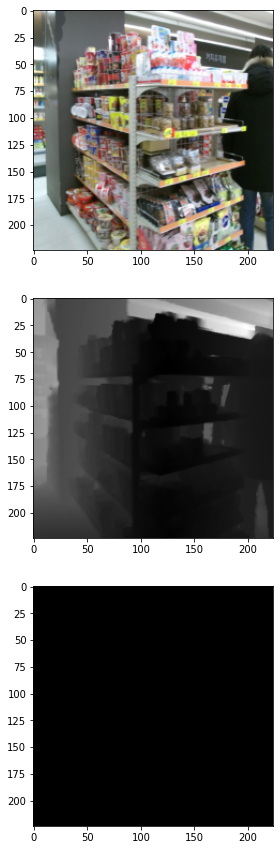

Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
After Convolutions:  torch.Size([32, 1, 224, 224])
Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
After Convolutions:  torch.Size([32, 1, 224, 224])
Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
After Convolutions:  torch.Size([32, 1, 224, 224])
Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
After Convolutions:  torch.Size([32, 1, 224, 224])
Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
After Convolutions:  torch.Size([32, 1, 224, 224])
Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
After Convolutions:  torch.Size([32, 1, 224, 224])
Original RGB Shape: 
torch.Size([32, 3, 224, 224])
After Mobile Net:  torch.Size([32, 1280, 7, 7])
A

KeyboardInterrupt: ignored

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

model_mobileNet = mobileNet_()

if torch.cuda.is_available():
    print("GPU available")
    model_mobileNet.cuda()

train(model_mobileNet, batch_size=32, learning_rate=0.0001, num_epochs=1)

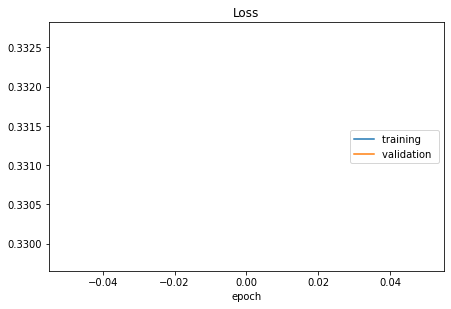

Loss
	training         	 (min:    0.330, max:    0.330, cur:    0.330)
	validation       	 (min:    0.333, max:    0.333, cur:    0.333)


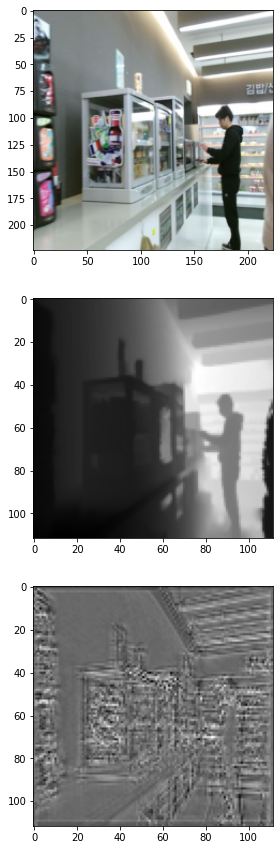

KeyboardInterrupt: ignored

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

model_ = Model()

if torch.cuda.is_available():
    print("GPU available")
    model_.cuda()

train(model_, batch_size=2, learning_rate=0.0001, num_epochs=1)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

cnnNet_ = cnnNet()

if torch.cuda.is_available():
    print("GPU available")
    cnnNet_.cuda()

train(cnnNet_, batch_size=2, learning_rate=0.0001, num_epochs=1)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

resNetModel_ = resNetModel()

if torch.cuda.is_available():
    print("GPU available")
    resNetModel_.cuda()

train(resNetModel_, batch_size=2, learning_rate=0.0001, num_epochs=1)

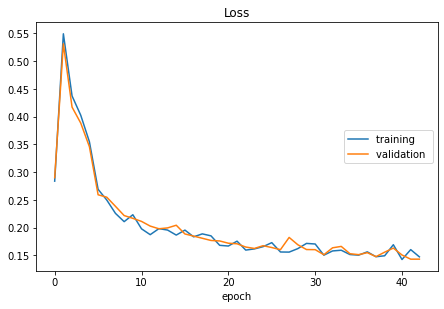

Loss
	training         	 (min:    0.143, max:    0.549, cur:    0.147)
	validation       	 (min:    0.143, max:    0.531, cur:    0.143)


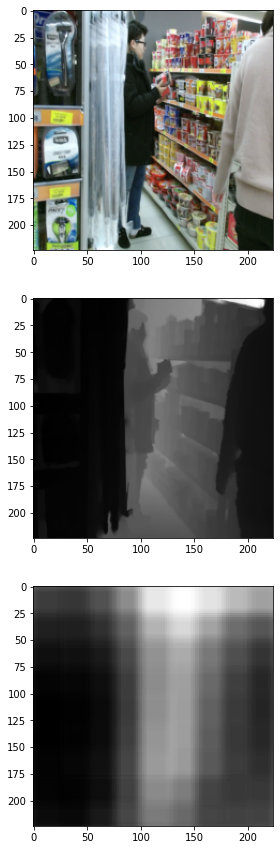

KeyboardInterrupt: ignored

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

denseNetModel_121 = denseNetModel_121()

if torch.cuda.is_available():
    print("GPU available")
    denseNetModel_121.cuda()

train(denseNetModel_121, batch_size=32, learning_rate=0.0001, num_epochs=1)